**Preprocessing BLAST data**

In [1]:
import pandas as pd
import os
from tqdm import tqdm

def merge_blast_results(file_path1, file_path2):
    df1 = process_blast_file(file_path1)
    df2 = process_blast_file(file_path2)
    result_df = pd.merge(df1, df2, left_on=['query_id', 'subject_id'], right_on=['subject_id', 'query_id'], suffixes=('_file1','_file2'))

    result_df_selected_columns = result_df[['query_id_file1', 'subject_id_file1', '%identity_file1', 'evalue_file1']]
    
    return result_df_selected_columns

def process_blast_file(file_path):
    data = []
    with open(file_path, 'r') as blast_file:
        for line in blast_file:
            if not line.startswith("#") and line.strip():
                values = line.strip().split("\t")
                data.append(values)

    columns = ['query_id','subject_id','%identity','alignment_length','mismatches','gap_opens','q.start','q.end','s.start','s.end','evalue','bit_score','query_length','subject_length','gaps'
]

    df = pd.DataFrame(data, columns=columns)
    
    df['%identity'] = df['%identity'].astype(float)
    df['evalue'] = df['evalue'].astype(float)
    df['q.end'] = df['q.end'].astype(float)
    df['q.start'] = df['q.start'].astype(float)
    df['query_length'] = df['query_length'].astype(float)
    
    filtered_df = df[(df['%identity'] > 30) & (df['evalue'] < 0.00001) & (((df['q.end']-df['q.start']+1)/df['query_length']) > 0.7)]
    
    
    df_unique = filtered_df.drop_duplicates(subset='query_id', keep='first') 
    df_selected_columns = df_unique[['query_id', 'subject_id', '%identity', 'evalue']]
    
    return df_selected_columns

def get_file_pairs(folder_path):
    files = os.listdir(folder_path)
    blast_files = [file for file in files if file.endswith(".bl")]

    file_pairs = []
    added_pairs = set()  # Un insieme per tenere traccia delle coppie già aggiunte

    for file in blast_files:
        genomeA, genomeB = file.replace("MEGA", "").replace(".bl","").split("_vs_")
        reverse_file = f"{genomeB}MEGA_vs_{genomeA}MEGA.bl"

        # Verifica se la coppia è già stata aggiunta in ordine inverso
        if (file, reverse_file) not in added_pairs and (reverse_file, file) not in added_pairs and (file, reverse_file) != (reverse_file, file):
            file_pairs.append((file, reverse_file))
            added_pairs.add((file, reverse_file))

    return file_pairs


def merge_all_blast_results(folder_path):
    file_pairs = get_file_pairs(folder_path)
    list_result_df = []

    for file_pair in tqdm(file_pairs, desc="Merging Blast Results", unit="file pair"):
        
        file_path1 = os.path.join(folder_path, file_pair[0])
        file_path2 = os.path.join(folder_path, file_pair[1])

        result_df = merge_blast_results(file_path1, file_path2)
        list_result_df.append(result_df)
        
    return list_result_df

# Percorso della cartella contenente i file BLAST
blast_folder_path = "ORF"

# Chiama la funzione per ottenere una lista di dataframe per ogni coppia simmetrica di match tra tutti i genomi ((21x21-21)/2)
result_reciprocal_hits = merge_all_blast_results(blast_folder_path)
#print(get_file_pairs(blast_folder_path))


Merging Blast Results: 100%|██████████| 15/15 [02:18<00:00,  9.25s/file pair]


In [2]:
#print(result_reciprocal_hits)
#print(len(result_reciprocal_hits))

[                  query_id_file1          subject_id_file1  %identity_file1  \
0     SarbXIII_+_572845-573042_1  Sbay13_+_791278-791463_1           53.704   
1      SarbXVI_+_671628-671864_0  Sbay16_+_707321-707560_2           48.529   
2      SarbXII_+_532871-532966_2  Sbay10_+_548825-548941_2           83.871   
3      SarbVII_-_472852-472706_2   Sbay7_-_471245-471135_1           80.556   
4      SarbVII_-_817358-817161_1   Sbay7_-_808749-808534_0           47.692   
...                          ...                       ...              ...   
6939     SarbXVI_+_251523-252401    Sbay16_+_280508-281386           76.027   
6940    SarbXIII_-_883290-885368     Sbay2_-_904781-906868           90.791   
6941      SarbXV_+_414514-415443     Sbay8_+_210272-211198           95.146   
6942    SarbXIII_+_798945-799994     Sbay2_+_821305-822354           88.539   
6943     SarbXVI_+_329981-330457    Sbay16_+_357733-358188           88.312   

       evalue_file1  
0      1.640000e-09  
1     

__Make a list of unique Genome names__

In [2]:
import re

def extract_prefixes(result_reciprocal_hits):
    unique_names = set()  # Utilizzo di un set per garantire l'unicità dei nomi

    for df in result_reciprocal_hits:
        for index, row in df.iterrows():
            subject_id = row['subject_id_file1']  # Assumendo che 'subject_id_file1' sia la colonna di interesse

            # Estrai le prime 3 lettere tramite regex
            match = re.match(r'^([a-zA-Z]{4})', subject_id)
            if match:
                name = match.group(1)

                # Aggiungi il nome alla lista di valori unici
                unique_names.add(name)

    return list(unique_names)

# Chiamata della funzione e stampa del risultato
unique_name_list = extract_prefixes(result_reciprocal_hits)
print(f"Number of unique Genomes: {len(unique_name_list)}")
print(unique_name_list)


Number of unique Genomes: 6
['Smik', 'Sbay', 'Spar', 'scaf', 'Skud', 'Scer']


__Filter only dataframes with a specific Genome__ 

In [3]:
def check_prefix_match(result_reciprocal_hits, prefix_to_search):
    matching_dataframes = []

    for df in result_reciprocal_hits:
        first_row = df.iloc[0]  # Estrai la prima riga del DataFrame

        # Estrai solo le prime 4 lettere dai prefissi nelle colonne
        prefix_col1 = first_row['query_id_file1'][:4]
        prefix_col2 = first_row['subject_id_file1'][:4]

        # Verifica se il prefisso corrisponde a quello da cercare
        if prefix_col1 == prefix_to_search or prefix_col2 == prefix_to_search:
            matching_dataframes.append(df)

    return matching_dataframes

prefix_to_search = "Scer"
matching_dataframes_list = check_prefix_match(result_reciprocal_hits, prefix_to_search)

# Stampa il numero di dataframe che corrispondono
print(f"Number of matching dataframes: {len(matching_dataframes_list)}")
print(matching_dataframes_list)


Number of matching dataframes: 5
[                 query_id_file1           subject_id_file1  %identity_file1  \
0     SarbXIV_-_315429-315313_1  ScerXIV_-_326629-326531_1           65.625   
1         SarbIII_+_3612-3776_0    ScerV_-_566027-565863_0           48.077   
2     SarbXII_+_532871-532966_2  ScerXII_+_576529-576645_1           70.370   
3     SarbVII_-_472852-472706_2  ScerVII_-_479992-479843_2           87.755   
4     SarbVII_-_817358-817161_1  ScerVII_-_851171-850950_1           46.154   
...                         ...                        ...              ...   
6660    SarbXVI_+_251523-252401    ScerXVI_+_271310-272194           70.548   
6661   SarbXIII_-_883290-885368   ScerIV_-_1147379-1149466           91.655   
6662     SarbXV_+_414514-415443     ScerXV_+_447439-448368           94.822   
6663   SarbXIII_+_798945-799994   ScerIV_+_1056551-1057600           91.117   
6664    SarbXVI_+_329981-330457    ScerXVI_+_348446-348952           83.333   

       evalue_fil

__Define two functions, first to understand wich is the correct column to merge, the second that merges all the selected dataframes__

def find_column_with_string(df, target_string):
    matching_columns = df.columns[df.iloc[0].str.startswith(target_string)]

    if len(matching_columns) == 0:
        raise ValueError(f"No column found with the specified string '{target_string}' in the first row.")

    return matching_columns[0]

def merge_on_prefix(dataframes_list, prefix_to_search):
    if len(dataframes_list) < 2:
        raise ValueError("At least two dataframes are required for merging.")

    result_df = pd.merge(dataframes_list[0], dataframes_list[1], left_on=find_column_with_string(dataframes_list[0], prefix_to_search), right_on=find_column_with_string(dataframes_list[1], prefix_to_search), how='inner', suffixes=('_left', '_right'))

    for i in range(2, len(dataframes_list)):
        column_to_mergeL = find_column_with_string(result_df, prefix_to_search)
        column_to_mergeR = find_column_with_string(dataframes_list[i], prefix_to_search)
        result_df = pd.merge(result_df, dataframes_list[i], left_on=column_to_mergeL, right_on=column_to_mergeR, how='inner', suffixes=(f'_left_{i}', f'_right_{i}'))

    return result_df


result = merge_on_prefix(matching_dataframes_list, prefix_to_search)
print(result.shape[0])


In [4]:
def find_column_with_string(df, target_string):
    matching_columns = []

    for col in df.columns:
        # Check for NaN values in the column
        if df[col].isna().all():
            continue

        # Convert column values to strings and check if it starts with the target string
        if str(df[col].iloc[0]).startswith(target_string):
            matching_columns.append(col)

    if len(matching_columns) == 0:
        raise ValueError(f"No column found with the specified string '{target_string}' in the first row.")

    return matching_columns[0]


def merge_on_prefix(dataframes_list, prefix_to_search):
    if len(dataframes_list) < 2:
        raise ValueError("At least two dataframes are required for merging.")

    result_df = pd.merge(dataframes_list[0], dataframes_list[1], left_on=find_column_with_string(dataframes_list[0], prefix_to_search), right_on=find_column_with_string(dataframes_list[1], prefix_to_search), how='inner', suffixes=('_left', '_right'))

    for i in range(2, len(dataframes_list)):
        column_to_mergeL = find_column_with_string(result_df, prefix_to_search)
        column_to_mergeR = find_column_with_string(dataframes_list[i], prefix_to_search)
        result_df = pd.merge(result_df, dataframes_list[i], left_on=column_to_mergeL, right_on=column_to_mergeR, how='inner', suffixes=(f'_left_{i}', f'_right_{i}'))

    return result_df


result = merge_on_prefix(matching_dataframes_list, prefix_to_search)
print(result.shape[0])


4632


In [8]:
#result.to_excel("total_core.xlsx", index=False)
print(result)

            query_id_file1_left    subject_id_file1_left_2  \
0      SarbIX_-_187950-186748_1     ScerIX_-_210923-212005   
1        SarbIX_+_49484-49567_2     ScerIX_+_69524-69607_2   
2      SarbIX_-_221583-220657_1     ScerIX_-_244657-245559   
3        SarbIX_+_69005-69121_2     ScerIX_+_89034-89147_0   
4     SarbXIV_+_517500-517616_0  ScerXIV_+_532134-532250_0   
...                         ...                        ...   
4627   SarbXIII_+_200461-202995   ScerXIII_+_217362-219878   
4628    SarbXVI_+_251523-252401    ScerXVI_+_271310-272194   
4629   SarbXIII_-_883290-885368   ScerIV_-_1147379-1149466   
4630     SarbXV_+_414514-415443     ScerXV_+_447439-448368   
4631   SarbXIII_+_798945-799994   ScerIV_+_1056551-1057600   

      %identity_file1_left  evalue_file1_left      query_id_file1_right  \
0                   77.260       0.000000e+00   Sbay9_-_200582-199431_1   
1                   85.185       1.160000e-08     Sbay9_+_64236-64319_0   
2                   79.667    

**Define a function to splitt CDS and ORF**

In [5]:
def CDS_or_ORF(df, column_name):
    # Split the specified column by "_"
    split_columns = df[column_name].str.split('_')

    # Create a mask for rows where values are split into 4 parts
    ORF = split_columns.apply(lambda x: len(x) == 4)
    
    # Create a mask for rows where values are split into 3 parts
    CDS = split_columns.apply(lambda x: len(x) == 3)

    # Create two dataframes based on the masks
    ORF = df[ORF].copy()
    CDS = df[CDS].copy()
    ORF.reset_index(drop=True, inplace=True)
    CDS.reset_index(drop=True, inplace=True)
    return ORF, CDS


In [6]:
core2_ORF, core2_CDS=CDS_or_ORF(matching_dataframes_list[-1],'query_id_file1')
core6_ORF, core6_CDS=CDS_or_ORF(result,'subject_id_file1_left_2')

In [30]:
print(core2_ORF.shape[0])
print(core6_ORF.shape[0])
print(core2_CDS.shape[0])
print(core6_CDS.shape[0])

10937
63
5118
4569


def filter_rows_with_3_parts(df):
    # Apply the condition to each row
    mask = df.apply(lambda row: all(len(str(value).split('_')) == 3 for value in row), axis=1)

    # Filter the dataframe based on the mask
    filtered_df = df[mask].copy()

    # Reset indices
    filtered_df.reset_index(drop=True, inplace=True)

    return filtered_df

def filter_rows_with_4_parts(df):
    # Apply the condition to each row
    mask = df.apply(lambda row: all(len(str(value).split('_')) == 4 for value in row), axis=1)

    # Filter the dataframe based on the mask
    filtered_df = df[mask].copy()

    # Reset indices
    filtered_df.reset_index(drop=True, inplace=True)

    return filtered_df

In [8]:
def filter_rows_with_3_parts(df):
    # Select only string columns
    string_columns = df.select_dtypes(include=['object']).columns

    # Apply the condition to each row for string columns
    mask = df[string_columns].apply(lambda row: all(len(str(value).split('_')) == 3 for value in row), axis=1)

    # Filter the dataframe based on the mask
    filtered_df = df[mask].copy()

    # Reset indices
    filtered_df.reset_index(drop=True, inplace=True)

    return filtered_df

def filter_rows_with_4_parts(df):
    # Select only string columns
    string_columns = df.select_dtypes(include=['object']).columns

    # Apply the condition to each row for string columns
    mask = df[string_columns].apply(lambda row: all(len(str(value).split('_')) == 4 for value in row), axis=1)

    # Filter the dataframe based on the mask
    filtered_df = df[mask].copy()

    # Reset indices
    filtered_df.reset_index(drop=True, inplace=True)

    return filtered_df


In [9]:
core6_filtered_CDS = filter_rows_with_3_parts(core6_CDS)
core6_filtered_ORF = filter_rows_with_4_parts(core6_ORF)
print(len(core6_filtered_CDS))
print(len(core6_filtered_ORF))

4270
62


In [10]:
core2_filtered_CDS = filter_rows_with_3_parts(core2_CDS)
core2_filtered_ORF = filter_rows_with_4_parts(core2_ORF)
print(len(core2_filtered_CDS))
print(len(core2_filtered_ORF))

4888
10931


In [23]:
#core6_filtered_ORF.to_excel("prova.xlsx", index=False)
print(core6_filtered_ORF)

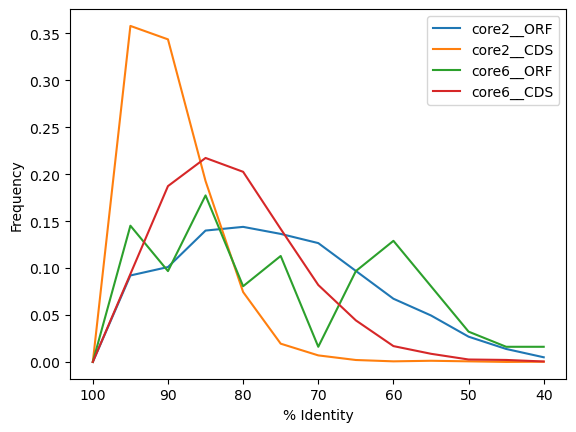

In [26]:
import pandas as pd
import matplotlib.pyplot as plt


# Calcola la frequenza delle righe per ogni valore di %identity_rounded
total_rows_ORF2 = len(core2_filtered_ORF)
total_rows_CDS2 = len(core2_filtered_CDS)
total_rows_ORF6 = len(core6_filtered_ORF)
total_rows_CDS6 = len(core6_filtered_CDS)

# Definisci gli intervalli di bin
bin_width = 5
bins = range(40, 106, bin_width)  # Intervallo da 0 a 100 con passo di 5

# Crea una funzione per il conteggio delle occorrenze nei bin
def count_occurrences(data):
    return pd.cut(data, bins=bins, include_lowest=True).value_counts(sort=False)

# Calcola il conteggio degli intervalli per ogni dataframe
counts_ORF2 = count_occurrences(core2_filtered_ORF['%identity_file1'])
counts_CDS2 = count_occurrences(core2_filtered_CDS['%identity_file1'])
counts_ORF6 = count_occurrences(core6_filtered_ORF['%identity_file1_right'])
counts_CDS6 = count_occurrences(core6_filtered_CDS['%identity_file1_right'])

# Calcola la frequenza dividendo il conteggio per il numero totale di righe corrispondenti a ciascun dataframe
freq_per_identity_ORF2 = counts_ORF2 / total_rows_ORF2
freq_per_identity_CDS2 = counts_CDS2 / total_rows_CDS2
freq_per_identity_ORF6 = counts_ORF6 / total_rows_ORF6
freq_per_identity_CDS6 = counts_CDS6 / total_rows_CDS6

# Crea un grafico
plt.plot(bins[:-1], freq_per_identity_ORF2, label='core2__ORF')
plt.plot(bins[:-1], freq_per_identity_CDS2, label='core2__CDS')
plt.plot(bins[:-1], freq_per_identity_ORF6, label='core6__ORF')
plt.plot(bins[:-1], freq_per_identity_CDS6, label='core6__CDS')

# Aggiungi le etichette agli assi
plt.xlabel('% Identity')
plt.ylabel('Frequency')

# Aggiungi una legenda
plt.legend()

# Inverti l'asse x
plt.gca().invert_xaxis()

plt.savefig("identity.jpg",format="jpg")

# Mostra il grafico
plt.show()


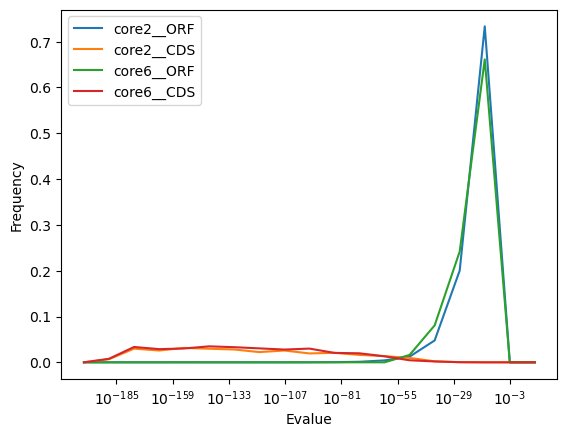

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calcola la frequenza delle righe per ogni valore di %identity_rounded
total_rows_ORF2 = len(core2_filtered_ORF)
total_rows_CDS2 = len(core2_filtered_CDS)
total_rows_ORF6 = len(core6_filtered_ORF)
total_rows_CDS6 = len(core6_filtered_CDS)

# Definisci gli intervalli di bin in modo logaritmico
num_bins = 20  # Puoi regolare questo valore in base alle tue esigenze
bins = np.logspace(-200, 20, num_bins)  # Partendo da 10^-6 fino a 1
#print(bins)
# Crea una funzione per il conteggio delle occorrenze nei bin
def count_occurrences(data):
    return pd.cut(data, bins=bins, include_lowest=True).value_counts(sort=False)

# Calcola il conteggio degli intervalli per ogni dataframe
counts_ORF2 = count_occurrences(core2_filtered_ORF['evalue_file1'])
counts_CDS2 = count_occurrences(core2_filtered_CDS['evalue_file1'])
counts_ORF6 = count_occurrences(core6_filtered_ORF['evalue_file1_right'])
counts_CDS6 = count_occurrences(core6_filtered_CDS['evalue_file1_right'])

# Calcola la frequenza dividendo il conteggio per il numero totale di righe corrispondenti a ciascun dataframe
freq_per_identity_ORF2 = counts_ORF2 / total_rows_ORF2
freq_per_identity_CDS2 = counts_CDS2 / total_rows_CDS2
freq_per_identity_ORF6 = counts_ORF6 / total_rows_ORF6
freq_per_identity_CDS6 = counts_CDS6 / total_rows_CDS6

# Crea un grafico
plt.plot(bins[:-1], freq_per_identity_ORF2, label='core2__ORF')
plt.plot(bins[:-1], freq_per_identity_CDS2, label='core2__CDS')
plt.plot(bins[:-1], freq_per_identity_ORF6, label='core6__ORF')
plt.plot(bins[:-1], freq_per_identity_CDS6, label='core6__CDS')

# Aggiungi le etichette agli assi
plt.xlabel('Evalue')
plt.ylabel('Frequency')
plt.xscale('log')

# Aggiungi una legenda
plt.legend()

plt.savefig("evalue.jpg",format="jpg")

# Mostra il grafico
plt.show()


In [18]:
print(min(core2_filtered_ORF['evalue_file1']))
print(max(core2_filtered_CDS['evalue_file1']))
print(min(core6_filtered_ORF['evalue_file1_right']))
print(max(core6_filtered_CDS['evalue_file1_right']))

3.06e-149
2.14e-24
1.69e-46
9.81e-22


In [186]:
#print(core2_filtered_ORF)
#print(core2_filtered_CDS)
print(core6_filtered_ORF)
#print(core6_filtered_CDS)

          query_id_file1_left    subject_id_file1_left_2  \
0      SarbIX_+_49484-49567_2     ScerIX_+_69524-69607_2   
1      SarbIX_+_69005-69121_2     ScerIX_+_89034-89147_0   
2   SarbXIV_+_517500-517616_0  ScerXIV_+_532134-532250_0   
3    SarbII_-_154736-154617_2   ScerII_-_164318-164199_0   
4     SarbXVI_-_81541-81470_0  ScerXVI_-_101435-101364_2   
..                        ...                        ...   
57  SarbXII_-_191708-191502_1  ScerXII_-_202097-201900_0   
58  SarbXVI_-_836889-836629_1  ScerXVI_-_888206-887931_2   
59      SarbV_-_76732-76661_2    ScerV_-_101922-101851_2   
60   SarbIV_-_339014-338940_2   ScerIV_-_310186-310112_1   
61  SarbXIV_-_497357-497130_2  ScerXIV_-_506049-505789_2   

    %identity_file1_left  evalue_file1_left      query_id_file1_right  \
0                 85.185       1.160000e-08     Sbay9_+_64236-64319_0   
1                 72.222       8.930000e-12     Sbay9_+_83769-83894_0   
2                 68.421       8.120000e-12  Sbay14_+_524788